**Mô tả bộ dữ liệu:**
* Đường dẫn lấy dữ liệu: https://www.kaggle.com/datasets/davilsena/ckdataset

*   **Hình ảnh trong bộ dữ liệu CK+ 48** được lưu trữ trong các thư mục riêng biệt, các thư mục được đặt tên theo nhãn cảm xúc:
 *   0 = 'anger', 1 = 'contempt',  2 = 'disgust',    3 = 'fear',    4 = 'happy',    5 = 'sadness',    6 = 'surprise'

**Mô tả quá trình huấn luyện:**

* Chuyển đổi tất cả hình ảnh sang màu xám
* Xác định nhãn cảm xúc theo trường hợp sử dụng.
* Cấu trúc của mô hình CNN:
    - Một lớp *Conv2D* đầu vào (với 32 bộ lọc) kết hợp với một lớp *MaxPooling2D*.,
    - 3 cặp lớp *Conv2D* (với 64, 128 và 256 bộ lọc) và *MaxPooling2D*.,
    - Một lớp *Dense* với 128 nút,
    - Một lớp *Dense* đầu ra với 3 nút.

# Import Library

In [1]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import os
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

# Import Dataset

In [2]:
dataset_folder='./input/CK+48'
sub_folders=os.listdir(dataset_folder)

sub_folders

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [3]:
i = 0
last = []
images = []
labels = []
temp = sub_folders

# Đọc từng thư mục trong thư mục dữ liệu chính
for sub_folder in sub_folders:
  sub_folder_index = temp.index(sub_folder)
  label = sub_folder_index

  if label in [4, 6]:    # Nhãn thuộc ['happy', 'surprise']
    new_label = 0        # Chuyển thành nhãn = positive
  elif label in [0, 5]:  # Nhãn thuộc ['anger', 'sadness']
    new_label = 1        # Chuyển thành nhãn = negative
  else:                  # Nhãn thuộc ['contempt', 'disgust', 'fear']
    new_label = 2        # Chuyển thành nhãn = neutral

  path = dataset_folder + '/' + sub_folder
  sub_folder_images = os.listdir(path)

  # Đọc từng hình ảnh trong thư mục con
  for image in sub_folder_images:
    image_path = path + '/' + image
    print(image_path + "\t" + str(new_label))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (48, 48))
    images.append(image)
    labels.append(new_label)
    i += 1
  last.append(i)


./input/CK+48/anger/S010_004_00000017.png	1
./input/CK+48/anger/S010_004_00000018.png	1
./input/CK+48/anger/S010_004_00000019.png	1
./input/CK+48/anger/S011_004_00000019.png	1
./input/CK+48/anger/S011_004_00000020.png	1
./input/CK+48/anger/S011_004_00000021.png	1
./input/CK+48/anger/S014_003_00000028.png	1
./input/CK+48/anger/S014_003_00000029.png	1
./input/CK+48/anger/S014_003_00000030.png	1
./input/CK+48/anger/S022_005_00000030.png	1
./input/CK+48/anger/S022_005_00000031.png	1
./input/CK+48/anger/S022_005_00000032.png	1
./input/CK+48/anger/S026_003_00000013.png	1
./input/CK+48/anger/S026_003_00000014.png	1
./input/CK+48/anger/S026_003_00000015.png	1
./input/CK+48/anger/S028_001_00000022.png	1
./input/CK+48/anger/S028_001_00000023.png	1
./input/CK+48/anger/S028_001_00000024.png	1
./input/CK+48/anger/S029_001_00000017.png	1
./input/CK+48/anger/S029_001_00000018.png	1
./input/CK+48/anger/S029_001_00000019.png	1
./input/CK+48/anger/S032_003_00000015.png	1
./input/CK+48/anger/S032_003_000

In [4]:
images_x = np.array(images)
labels_y = np.array(labels)

# Chia giá trị pixel của hình ảnh cho 255 để giảm khối lượng tính toán
images_x = images_x/255

In [5]:
images_x.shape

(981, 48, 48)

In [6]:
# Mã hóa nhãn
num_of_classes = 3
labels_y_encoded = tf.keras.utils.to_categorical(labels_y,num_classes=num_of_classes)

# Chia tệp Train / Test

In [7]:
X_train, X_test, Y_train, Y_test= train_test_split(images_x, labels_y_encoded,test_size=0.25, random_state=10)

In [8]:
len(X_train)

735

In [9]:
len(X_test)

246

# Xây dựng mô hình CNN

In [10]:
input = Input(shape = (48,48,1))

conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4)

dense_1 = Dense(128,activation='relu')(flatten)

drop_1 = Dropout(0.2)(dense_1)

output = Dense(3,activation="sigmoid")(drop_1)

In [11]:
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                             

# Huấn luyện 

In [12]:
fle_s='./output/emotion_model.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]

In [13]:
save = model.fit(X_train,Y_train,batch_size=32,validation_data=(X_test,Y_test),epochs=50,callbacks=[callback_list])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.2878 - accuracy: 0.4422
Epoch 1: loss improved from inf to 1.28782, saving model to ./output\emotion_model.h5
23/23 [==============================] - 11s 62ms/step - loss: 1.2878 - accuracy: 0.4422 - val_loss: 1.1874 - val_accuracy: 0.4756
Epoch 2/50
19/23 [=======================>......] - ETA: 0s - loss: 1.1904 - accuracy: 0.4737
Epoch 2: loss improved from 1.28782 to 1.18718, saving model to ./output\emotion_model.h5
23/23 [==============================] - 0s 10ms/step - loss: 1.1872 - accuracy: 0.4612 - val_loss: 1.1364 - val_accuracy: 0.4756
Epoch 3/50
21/23 [==========================>...] - ETA: 0s - loss: 1.1327 - accuracy: 0.4643
Epoch 3: loss improved from 1.18718 to 1.13298, saving model to ./output\emotion_model.h5
23/23 [==============================] - 0s 9ms/step - loss: 1.1330 - accuracy: 0.4612 - val_loss: 1.1300 - val_accuracy: 0.4756
Epoch 4/50
18/23 [======================>.......] - ETA: 0s - 

# Đánh giá mô hình

In [14]:
# Lấy train test loss, accuracy

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

Text(0.5, 0.92, 'Biểu đồ Loss, Accuracy qua từng epoc')

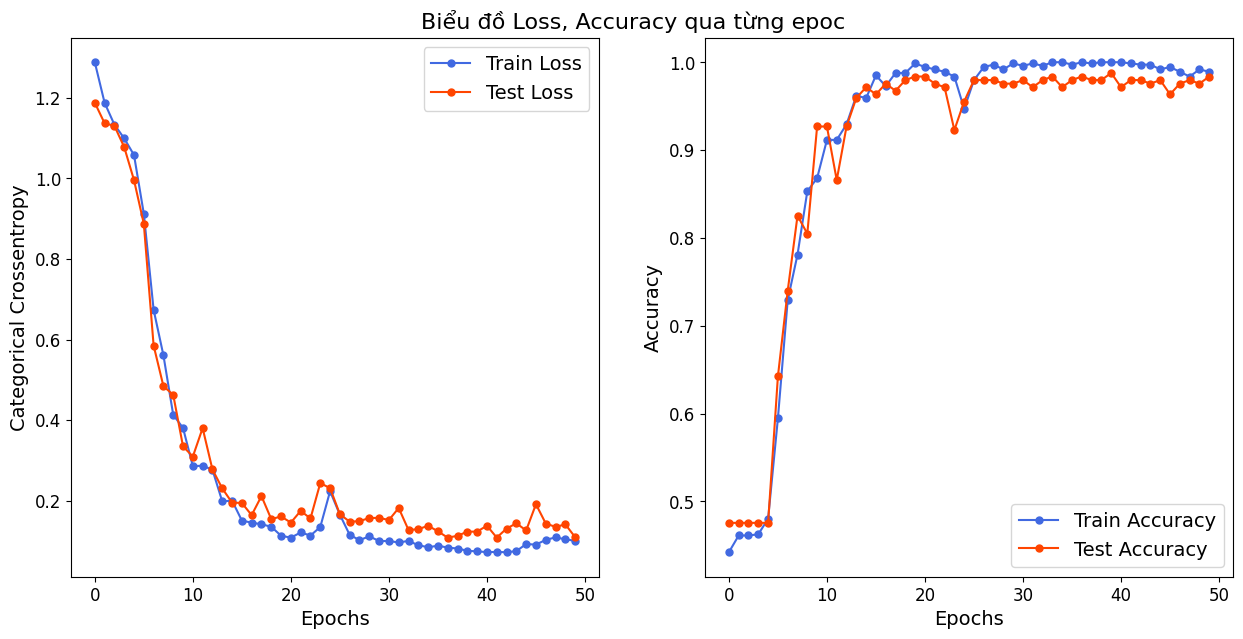

In [15]:
# Vẽ biểu đồ accuracy, loss qua từng epoc

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Biểu đồ Loss, Accuracy qua từng epoc", fontsize=16)